# Erster Handelsalgorithmus
## Pairs Trading

Pairs Trading ist eine Strategie, die zwei stark korrelierte Aktien verwendet. Wir können dann den Preisunterschied der beiden Aktien als Signal dafür verwenden, ob sich eine der beiden aus der Korrelation mit der anderen herausbewegt. Es ist eine ältere Strategie, die klassischerweise zu Anfang eingeführt wird, um algorithmisches Handeln zu erlernen. Es gibt eine fantastische vollständige Anleitung und Ausarbeitung auf Investopedia, und zwar [hier](http://www.investopedia.com/university/guide-pairs-trading/)! **Wir empfehlen, unbedingt den ganzen Artikel zu lesen, bevor Du weitermachst; er ist unterhaltsam und informativ!**


Erstellen wir unseren ersten grundlegenden Handelsalgorithmus! Dies ist eine Übung im Umgang mit Quantopian, **KEINE** realistische Repräsentation eines guten ALgorithmus! Verwende niemals etwas so Simples in der echten Welt! Dies ist eine stark vereinfachte Version von Pairs Trading; wir werden manche Faktoren, wie Kointegration, nicht beachten!

In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline

import quandl

## United Airlines und American Airlines

In [104]:
start = '07-01-2015'
end = '07-01-2017'

In [105]:
united = quandl.get('WIKI/UAL',start_date=start,end_date=end)
american = quandl.get('WIKI/AAL',start_date=start,end_date=end)

In [106]:
united.head()

Open   High    Low  Close     Volume  Ex-Dividend  Split Ratio  \
Date                                                                          
2015-01-07  64.96  66.11  64.00  65.53  5133939.0          0.0          1.0   
2015-01-08  65.70  67.52  65.41  66.64  6889597.0          0.0          1.0   
2015-01-09  66.76  66.97  64.90  65.34  3488027.0          0.0          1.0   
2015-01-12  66.16  66.85  63.84  65.92  5246008.0          0.0          1.0   
2015-01-13  66.84  68.26  65.45  66.41  6265791.0          0.0          1.0   

            Adj. Open  Adj. High  Adj. Low  Adj. Close  Adj. Volume  
Date                                                                 
2015-01-07      64.96      66.11     64.00       65.53    5133939.0  
2015-01-08      65.70      67.52     65.41       66.64    6889597.0  
2015-01-09      66.76      66.97     64.90       65.34    3488027.0  
2015-01-12      66.16      66.85     63.84       65.92    5246008.0  
2015-01-13      66.84      68.26     65.45       66.41    6265791.0

In [107]:
american.head()

Open   High    Low  Close      Volume  Ex-Dividend  Split Ratio  \
Date                                                                           
2015-01-07  53.38  53.65  52.12  53.01  10069816.0          0.0          1.0   
2015-01-08  53.48  54.28  53.25  53.66   9672064.0          0.0          1.0   
2015-01-09  53.67  53.91  51.82  52.02  12290046.0          0.0          1.0   
2015-01-12  51.06  51.45  49.20  49.58  18261336.0          0.0          1.0   
2015-01-13  50.12  51.43  49.46  50.40  12259271.0          0.0          1.0   

            Adj. Open  Adj. High   Adj. Low  Adj. Close  Adj. Volume  
Date                                                                  
2015-01-07  52.103884  52.367430  50.874006   51.742730   10069816.0  
2015-01-08  52.201494  52.982369  51.976992   52.377191    9672064.0  
2015-01-09  52.386951  52.621214  50.581178   50.776397   12290046.0  
2015-01-12  49.839347  50.220023  48.023812   48.394728   18261336.0  
2015-01-13  48.921819  50.200501  48.277597   49.195125   12259271.0

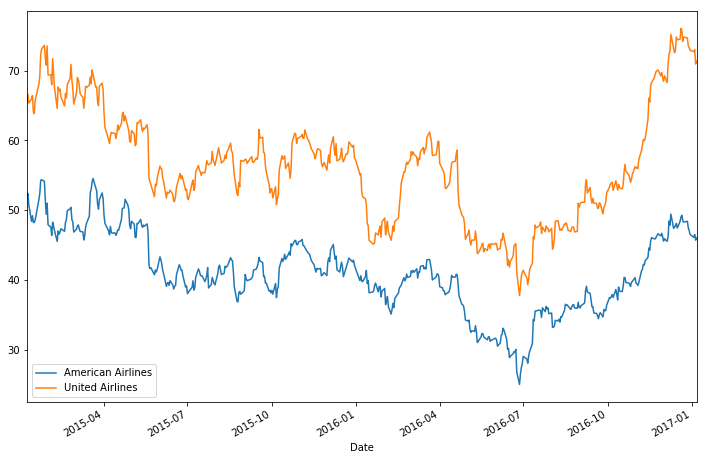

In [108]:
american['Adj. Close'].plot(label='American Airlines',figsize=(12,8))
united['Adj. Close'].plot(label='United Airlines')
plt.legend()

## Preisdifferenz (Spread) und Korrelation

In [126]:
np.corrcoef(american['Adj. Close'],united['Adj. Close'])

array([[ 1.        ,  0.92145101],
       [ 0.92145101,  1.        ]])

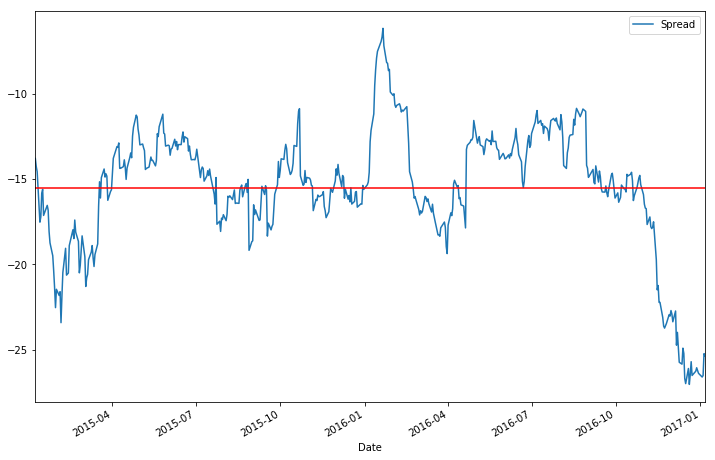

In [117]:
spread = american['Adj. Close'] - united['Adj. Close']
spread.plot(label='Spread',figsize=(12,8))
plt.axhline(spread.mean(),c='r')
plt.legend()

### Normalisierung mit  Z-Score

In [119]:
def zscore(stocks):
    return (stocks - stocks.mean()) / np.std(stocks)

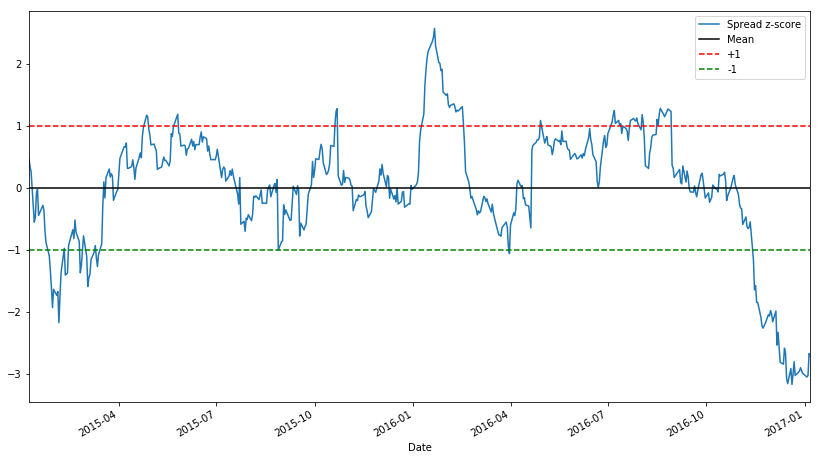

In [127]:
zscore(spread).plot(figsize=(14,8))
plt.axhline(zscore(spread).mean(), color='black')
plt.axhline(1.0, c='r', ls='--')
plt.axhline(-1.0, c='g', ls='--')
plt.legend(['Spread z-score', 'Mean', '+1', '-1']);

### Rollender Z-Score

Unsere Marge ist zur Zeit American-United. Entscheiden wir, wie wir dies auf einer rollenden Grundlage für unsere Verwendung in Quantopian berechnen.

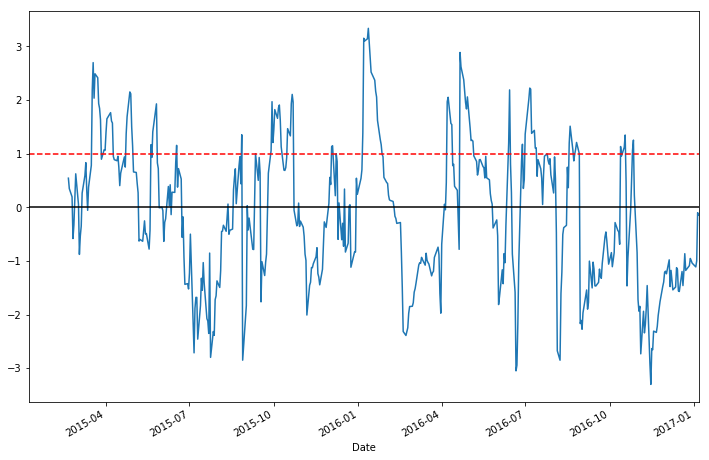

In [133]:
#1-Tages gleitender Mittelwert des Preisunterschieds
spread_mavg1 = spread.rolling(1).mean()

# 30-Tages gleitender Mittelwert des Preisunterschieds
spread_mavg30 = spread.rolling(30).mean()

# Nimm eine 30-Tages rollende Standardabweichung
std_30 = spread.rolling(30).std()

# Berechne den Z-Score für jeden einzelnen Tag
zscore_30_1 = (spread_mavg1 - spread_mavg30)/std_30



zscore_30_1.plot(figsize=(12,8),label='Rolling 30 day Z score')
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--');

## Implementation der Strategie

#### WARNUNG: DU SOLLTEST NICHT WIRKLICH DAMIT HANDELN!

In [ ]:
import numpy as np
 
def initialize(context):
    """
    Wird einmal zu Beginn des Algorithmus aufgerufen.
    """   
    
    # Jeden Tag kontrollieren wir den Status des Pairs 
    schedule_function(check_pairs, date_rules.every_day(), time_rules.market_close(minutes=60))
    
    # Unsere zwei Airlines
    context.aa = sid(45971) #aal
    context.ual = sid(28051) #ual   
    
    # Marker, um uns zu sagen, ob wir gerade in einem Handel sind
    context.long_on_spread = False
    context.shorting_spread = False


def check_pairs(context, data):
    
    # Aus Bequemlichkeit
    aa = context.aa
    ual = context.ual
    
    # Preishistorie erfassen
    prices = data.history([aa, ual], "price", 30, '1d')
    
 
    # Wir müssen .iloc[-1:] verwenden, um ein Datenframe statt Reihen zu bekommen
    short_prices = prices.iloc[-1:]
    
    # Erfasse den langen 30-Tages beweglichen Durchschnitt
    mavg_30 = np.mean(prices[aa] - prices[ual])
    
    # Erfasse die Standardabweichung des 30 Tage langen Fensters
    std_30 = np.std(prices[aa] - prices[ual])
    
    # Erfasse den kürzeren 1-Tages beweglichen Durchschnitt
    mavg_1 = np.mean(short_prices[aa] - short_prices[ual])
    
    # Berechne den Z-Score
    if std_30 > 0:
        zscore = (mavg_1 - mavg_30)/std_30
    
        # Unsere zwei Eintragsfälle
        if zscore > 0.5 and not context.shorting_spread:
            # Marge = aa - ual
            order_target_percent(aa, -0.5) # oben kurz (short)
            order_target_percent(ual, 0.5) # unten lang (long)
            context.shorting_spread = True
            context.long_on_spread = False
            
        elif zscore < -0.5 and not context.long_on_spread:
            # Marge = aa - ual
            order_target_percent(aa, 0.5) # oben kurz (short)
            order_target_percent(ual, -0.5) # unten lang (long)
            context.shorting_spread = False
            context.long_on_spread = True
            
        # Unser Exit-Fall
        elif abs(zscore) < 0.1:
            order_target_percent(aa, 0)
            order_target_percent(ual, 0)
            context.shorting_spread = False
            context.long_on_spread = False
        
        record('zscore', zscore)